In [56]:
# import shapely.geometry
# import pyproj
import osmnx as ox
import geopandas as gpd
import pandas as pd
# from geopandas import GeoDataFrame
# import matplotlib.pyplot as plt
import csv
import networkx as nx
import numpy as np

# from shapely.geometry import Polygon
# from shapely.geometry import Point

# ox.settings.use_cache=True
# ox.settings.log_console=True

In [2]:
# pyproj.datadir.set_data_dir('C:\\Users\\isaldiviagonzatti\\anaconda3\\envs\\ox\\Library\\share\\proj')
# pyproj.datadir.get_data_dir()

### Example with Pital

In [15]:
xlon = -84.278967
ylat = 10.476319
point = ylat, xlon # center of PA field near Pital

examG = ox.graph_from_point(point, network_type='all_private', dist=1000)

# impute missing edge speeds and add travel times
#G = ox.add_edge_speeds(G)
#G = ox.add_edge_travel_times(G)

In [16]:
# calculate route minimizing some weight. We use random points in the network
orig, dest = list(examG)[4], list(examG)[-1]
route = nx.shortest_path_length(examG, orig, dest, weight='length')

In [17]:
print('Lenght of the route between the two points in meters is ' + str(round(route)))

Lenght of the route between the two points in meters is 893


In [18]:
unique_edges = list(examG)[4], list(examG)[-1]

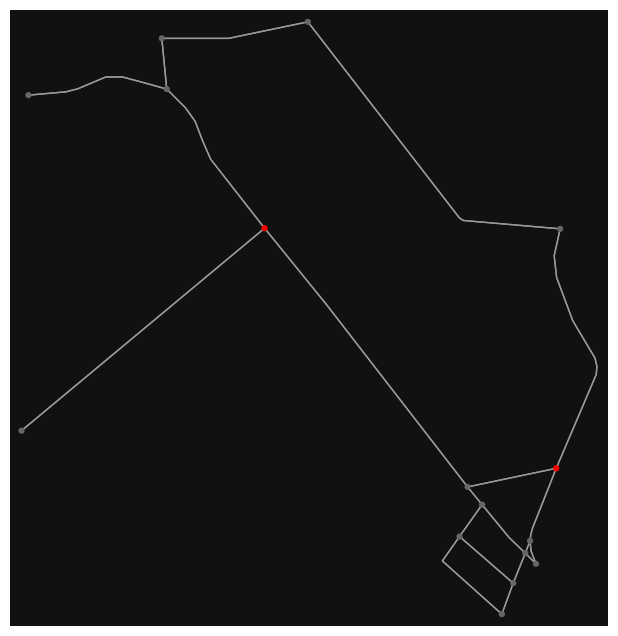

In [19]:
# In yellow is the centoid, in red we see the nearest steet to the centroid
ec = ['r' if e in unique_edges else '#666666' for e in examG.nodes]
#fig, ax = ox.plot_graph(G, edge_color=ec, edge_linewidth=1, node_size=0, show=False)
fig, ax = ox.plot_graph(examG, node_color=ec, edge_linewidth=1, node_size=20, show=False)

### Load PAL fields nodes and candidate nodes

In [18]:
with open(r'C:\Users\isaldiviagonzatti\Downloads\gitFiles/MScThesisCode/FLP/output/nearestNodePAL.csv', newline='') as f:
    reader = csv.reader(f)
    palFields = list(reader)

origs = list(set(palFields[0]))

In [19]:
for i in range(0, len(origs)):
    origs[i] = int(origs[i])

In [20]:
with open(r'C:\Users\isaldiviagonzatti\Downloads\gitFiles/MScThesisCode/FLP/output/canNetwork.csv', newline='') as f:
    reader = csv.reader(f)
    candidates = list(reader)

dests = list(set(candidates[0]))

In [21]:
for i in range(0, len(dests)):
    dests[i] = int(dests[i])

In [22]:
origs = pd.DataFrame(origs, columns=['origs'])
dests = pd.DataFrame(dests, columns=['dests'])

#### Create a dataframe with all combinations of origin-candidates

In [23]:
matrix = origs.merge(dests, how='cross')
print('We have ' + str(len(matrix)) + ' paths')

We have 565510 paths


In [24]:
matrix.dtypes

origs    int64
dests    int64
dtype: object

#### Load network of Costa Rica

In [9]:
## network file
networkFile = r'C:\Users\isaldiviagonzatti\Downloads\gitFiles/MScThesisCode/FLP/output/strongNetwork.gpkg'

In [10]:
#load road network
gdf_nodes = gpd.read_file(networkFile, layer='nodes').set_index('osmid')
gdf_edges = gpd.read_file(networkFile, layer='edges').set_index(['u', 'v', 'key'])
assert gdf_nodes.index.is_unique and gdf_edges.index.is_unique

In [11]:
%%time
# convert the node/edge GeoDataFrames to a MultiDiGraph
graph_attrs = {'crs': 'epsg:4326', 'simplified': True}
G = ox.graph_from_gdfs(gdf_nodes, gdf_edges, graph_attrs)

CPU times: total: 4.03 s
Wall time: 4.05 s


In [12]:
%%time
G_proj = ox.project_graph(G)

CPU times: total: 5.73 s
Wall time: 5.8 s


In [46]:
sampl_df=matrix.head(10).copy() 

In [47]:
# append points from example above to check errors
# new_row = {'origs': orig, 'dests':dest}
# sampl_df = sampl_df.append(new_row, ignore_index=True)
# sampl_df

In [26]:
#test = pd.DataFrame(sampl_df.loc[5])
#test = test.T

In [48]:
dest_point = (10.1108589, -83.5211883)

orig_point = (10.5127665, -84.4425312)

In [ ]:
%%time
#OPTION 1: recursively remove unsolvable origin/destination nodes and re-try
G2 = G.copy()
solved = False
while not solved:
    try:
        orig_node = ox.nearest_nodes(G2,-84.2929,  10.4358)
        dest_node = ox.nearest_nodes(G2, -84.4276,  10.3138)
        print(nx.shortest_path_length(G2, orig_node, dest_node, weight='length'))
        solved = True
    except nx.exception.NetworkXNoPath:
        G2.remove_nodes_from([orig_node, dest_node])

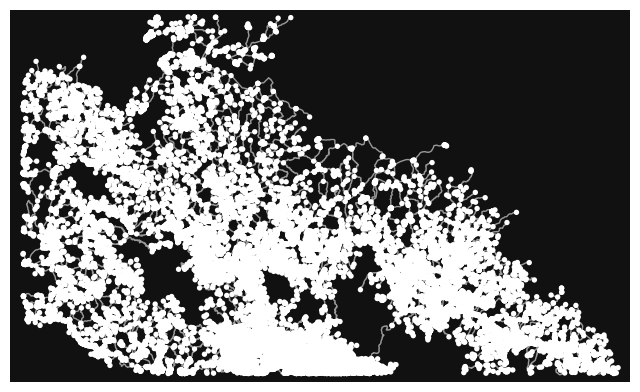

In [66]:
fig, ax = ox.plot_graph(G)

In [ ]:
%%time
def short_path_length(row):
    return nx.shortest_path_length(G, row['Orgin_nodes'], row['Destination_nodes'], weight='length')
sampl_df['short_path_length_2'] = sampl_df.apply(short_path_length, axis=1)

In [57]:
%%time
def short_path_length(row):
    return nx.shortest_path_length(G, row['origs'], row['dests'], weight='length')
sampl_df['path_length'] = sampl_df.apply(short_path_length, axis=1)

NetworkXNoPath: Node 1789079253 not reachable from 5605571665

In [64]:
ox.shortest_path(G, 2113132703, 185486762, weight='length')

NodeNotFound: Either source 2113132703 or target 185486762 is not in G

In [113]:
%%time
sampl_df['path_length'] = nx.shortest_path_length(G, sampl_df['origs'], sampl_df['dests'], weight="length")

NodeNotFound: Node 0    3929165138
1    3929165138
2    3929165138
3    3929165138
4    3929165138
5    1682508364
Name: origs, dtype: int64 not found in graph

In [114]:
%%time
sampl_df['path_length'] = ox.shortest_path(G, sampl_df['origs'], sampl_df['dests'], weight="length")

NodeNotFound: Either source 3929165138 or target 1182031896 is not in G

In [47]:
tryout = [int(sum(ox.utils_graph.get_route_edge_attributes(G, sampl_df['path_length'][i], "length"))) for i in range(len(sampl_df['path_length']))]

TypeError: 'float' object is not subscriptable

In [ ]:
### something else you can try, with vector

%%time
def short_path_length (node1,node2):
     return nx.shortest_path_length(G, node1, node2,weight='length')

sampl_df['short_path_length_intr3']=np.vectorize(short_path_length)(sampl_df['Orgin_nodes'],sampl_df['Destination_nodes'])

In [ ]:
G = ox.graph_from_place("Ville de Quebec, QC, Canada")
print("graph downloaded")
Gp = ox.project_graph(G)
print("graph projected")

points = ox.utils_geo.sample_points(ox.get_undirected(Gp), 1000)
print("points are ready")
gdf = gpd.GeoDataFrame(geometry=gpd.GeoSeries(points))
gdf["id"] = gdf.index
print(type(gdf))
gdf = gdf.set_geometry("geometry")

gdf = gdf.to_crs(epsg=4326)
# ax = gdf2.plot()

# cx.add_basemap(ax ,zoom='auto', crs=gdf.crs.to_string(), source=cx.providers.OpenStreetMap.Mapnik)


trans_modes = ['drive', 'bike', 'walk']


bbx = gdf.total_bounds
# print(bbx)

bbx_north=bbx[3]
bbx_south=bbx[1]
bbx_east=bbx[2]
bbx_west=bbx[0]


# Cross join the geodataframe with itself
gdf = pd.merge(gdf, gdf, how="cross", suffixes=("_o", "_d"))
# Delete the rows with the same point
gdf = gdf[gdf["id_o"] != gdf["id_d"]]
print("GDF is crosse producted")

origins_x = list(gdf['geometry_o'].x)
origins_y = list(gdf['geometry_o'].y)
destinations_x = list(gdf['geometry_d'].x)
destinations_y = list(gdf['geometry_d'].y)

# Downloading network for each mode of transport
for mode in trans_modes:
    
    print("calculations for this mode of transoprt is started:  " + mode )
    G = ox.graph_from_bbox(bbx_north, bbx_south, bbx_east, bbx_west, network_type=mode)
    print("The graph is downloaded")

    origin_nodes = ox.distance.nearest_nodes(G, origins_x, origins_y)
    print("Nearest origin nodes are found")
    destination_nodes = ox.distance.nearest_nodes(G, destinations_x, destinations_y)
    print("nearest destination points are found")
    
    routes = ox.shortest_path(G, origin_nodes, destination_nodes, weight='length')
    print("routes are calculated")
#     gdf['routes'] = routes

    gdf['length_' + str(mode)] = [int(sum(ox.utils_graph.get_route_edge_attributes(G, routes[i], "length"))) for i in range(len(routes))]
    print("length are calculated")
    if mode == 'drive':
        # impute speed on all edges missing data
        G = ox.add_edge_speeds(G)

        # calculate travel time (seconds) for all edges
        G = ox.add_edge_travel_times(G) 
        gdf['duration_' + str(mode)] = [int(sum(ox.utils_graph.get_route_edge_attributes(G, routes[i], "travel_time"))) for i in range(len(routes))]

    elif mode == 'bike':
        gdf['duration_' + str(mode)] = gdf['length_' + str(mode)] / avg_bike_speed
        gdf['duration_' + str(mode)] = gdf['duration_' + str(mode)].astype('int')

        
    elif mode == 'walk':
        gdf['duration_' + str(mode)] = gdf['length_' + str(mode)] / avg_walk_speed
        gdf['duration_' + str(mode)] = gdf['duration_' + str(mode)].astype('int')

print("Starting to calculate Euclidean distance")
gdf['geometry_o']=gdf['geometry_o'].to_crs(epsg=3979)
gdf['geometry_d']=gdf['geometry_d'].to_crs(epsg=3979)
gdf['Euclidean_Dist'] = gdf['geometry_o'].distance(gdf['geometry_d']).apply(int)

# changing CRS back to 4326 to have lat long for output file
gdf['geometry_o']=gdf['geometry_o'].to_crs(epsg=4326)
gdf['geometry_d']=gdf['geometry_d'].to_crs(epsg=4326)


print("All calculations are done. Ready to write in excel")

# removing the deleted indice.
gdf.reset_index()
num_out_excels = math.ceil(gdf.shape[0] / 500000 )
for i in range(num_out_excels):
    print(i)
    gdf.loc[i: (i+1)*500000,:].to_excel("output_"+ str(i) +".xlsx")
    
